In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import random
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display
import open3d as o3d

from Libraries.dataloader import DataLoader
# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

#  Inicjalizowane danych


In [4]:
device = 'cuda'

# Załadowanie danych
Ładujemy dane do zmiennych a następnie odpowiednio przekształcamy

In [5]:
# Transformations

class GaussianNoise(object):
    def __init__(self, p=0.5, mean=[0.0, 0.5], std=[1.0, 1.0]):
        self.p    = p
        self.std  = np.random.uniform(std[0],std[1])
        self.mean = np.random.uniform(mean[0],mean[1])
        
    def __call__(self, tensor):
        if random.random() < self.p:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        else:
            return tensor 


DataAug = transforms.Compose([
    transforms.ColorJitter(
        brightness=[0.5,1.5],
        contrast=[0.5, 1.5],
        saturation=[0.5, 1.5],
        hue=[-0.1,0.1],
    ),
    transforms.GaussianBlur(
        kernel_size=3,
        sigma=(0.1, 9.0)
    ),
#     transforms.RandomErasing(
#         p=0.1,
#         scale=(0.01, 0.1),
#         ratio=(0.01, 3.3),
#         value=0,
#     ),
    GaussianNoise(
        p=0.2,
        mean=[0.0, 0.1],
        std=[0.01, 0.3]
    )
])

In [6]:
# ResizeData = transforms.Resize([256, 320], interpolation=transforms.InterpolationMode.NEAREST)
# RGBtoGRAY = transforms.Grayscale(num_output_channels=1)

In [7]:
# # Set root path
# DATASET_ROOTDIR='/home/el_zlociako/Documents/Praca_inzynierska/Dataset/'

# df = pd.read_csv(f'{DATASET_ROOTDIR}files/data.csv') 
# df_INPUT_DEPTH = df[['depth_img_I', 'depth_img_II']]
# df_INPUT_RGB = df[['rgb_img_I', 'rgb_img_II']]
# df_OUTPUT = df[['x1','y1','z1','x2','y2','z2']]

# RGBimg_begin = load_from_csv(DATASET_ROOTDIR, df_INPUT_RGB, 'rgb' ,0)
# DEPTHimg_begin = load_from_csv(DATASET_ROOTDIR, df_INPUT_DEPTH, 'depth',0)
# DEPTHimg_end = load_from_csv(DATASET_ROOTDIR, df_INPUT_DEPTH, 'depth', 1)

# # Taking first rgb image
# rgb_in = torch.IntTensor(RGBimg_begin.transpose(0,3,1,2))
# gray_in = RGBtoGRAY(rgb_in).div(255)
# # plt.imshow(gray_in[0].numpy().transpose(1,2,0),cmap='gray')

# # Taking depth beginning state of the movement
# depthBeg_in = NormImage(DEPTHimg_begin,5500,reshape=True)

# # Taking depth end state of the movement
# depthEnd_in = NormImage(DEPTHimg_end,5500,reshape=True)

# # Taking depth difference between movements
# depthDiff_in = NormImage(abs(DEPTHimg_begin - DEPTHimg_end),5500,reshape=True)

# # Taking outputs
# axis_out = df_OUTPUT.values
# axis_out = torch.Tensor(axis_out)

# RGBD_input = ResizeData(torch.cat((gray_in, depthBeg_in, depthDiff_in),axis=1))


# print(RGBD_input.shape)
# # RGBD_input = DDD_in

# Load Data

In [8]:
DATASET_ROOTDIR='/home/el_zlociako/Documents/Praca_inzynierska/Dataset/'
dl = DataLoader()
RGBD_input,axis_out = dl.load(DATASET_ROOTDIR, 'files_ArUco/data_ArUco.csv', 'R')

# RGB + D 
Na wejście do modelu zostanie podany tensor zawieający kombinację RGB + D 

In [9]:
X_train, X_validation, y_train, y_validation = train_test_split(RGBD_input, axis_out, test_size=0.2)
print(X_train.shape)

torch.Size([311, 3, 256, 320])


In [9]:
X_train_aug = X_train.clone()

for i in range(X_train_aug.shape[0]):
     X_train_aug[i] = DataAug(X_train_aug[i])
        
y_train = torch.cat((y_train, y_train),axis=0)
X_train = torch.cat((X_train, X_train_aug),axis=0)

In [19]:
AoRD_trainDataset = TensorDataset(X_train, y_train)
AoRD_validationDataset = TensorDataset(X_validation, y_validation)

In [20]:
train_loader = DataLoader(AoRD_trainDataset, batch_size=8, shuffle=True)
validation_loader = DataLoader(AoRD_validationDataset, batch_size=8, shuffle=True)

# Wyciąganie pojedyńczego elementu z batcha
Można zrobić to na kilka sposobów, ale ten jest najszybszy

In [21]:
# for b, (X_train, y_train) in enumerate(train_loader):
#     pass

# Stworzenie modelu
Nazwałem model AoRNet od angielsiego **A**xis **o**f **R**rotation oraz od nazwy modelu matki Res**Net**`u 

In [22]:
class AoRNet(nn.Module):
    def __init__(self,pretrained=False ,input_channels=3, output_size=6):
        super().__init__()
        self.resnet50 = models.resnet50(pretrained=pretrained)
        self.resnet50.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet50.fc = nn.Linear(in_features=2048, out_features=output_size, bias=True)
    
    def forward(self, X):
        return self.resnet50(X)

In [23]:
Model = AoRNet().to(device)

In [24]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(Model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=5, factor=0.1, min_lr=0.000000001)

In [25]:
epochs = 150

train_losses = []
validation_losses = []

for i in range(epochs):
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        X_train = X_train.to(device)
        y_train = y_train.to(device)
                
        # Apply the model
        y_pred = Model(X_train)
        loss = criterion(y_pred, y_train)
#         torch.cuda.empty_cache()
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1 == 0:
            print(f'epoch: {i+1:2}  batch: {b}  loss: {loss.item():10.8f}')
    
    train_losses.append(loss.cpu().detach().numpy())
    scheduler.step(loss)
    
    # Run the validationing batches
    with torch.no_grad():
        for b, (X_validation, y_validation) in enumerate(validation_loader):
            # Apply the model
            
            X_validation = X_validation.to(device)
            y_validation = y_validation.to(device)
            
            y_val = Model(X_validation)
    loss = criterion(y_val, y_validation)
    validation_losses.append(loss.cpu().detach().numpy())
#     validation_correct.append(tst_corr)

epoch:  1  batch: 1  loss: 1.18806052
epoch:  1  batch: 2  loss: 1.47208691
epoch:  1  batch: 3  loss: 2.04500079
epoch:  1  batch: 4  loss: 1.27593637
epoch:  1  batch: 5  loss: 1.19833136
epoch:  1  batch: 6  loss: 0.97611374
epoch:  1  batch: 7  loss: 0.83360738
epoch:  1  batch: 8  loss: 0.44806045
epoch:  1  batch: 9  loss: 0.42087898
epoch:  1  batch: 10  loss: 0.54907072
epoch:  1  batch: 11  loss: 0.48083100
epoch:  1  batch: 12  loss: 0.45911616
epoch:  1  batch: 13  loss: 0.40723869
epoch:  1  batch: 14  loss: 0.31320795
epoch:  1  batch: 15  loss: 0.31948349
epoch:  1  batch: 16  loss: 0.43231985
epoch:  1  batch: 17  loss: 0.37558851
epoch:  1  batch: 18  loss: 0.43262142
epoch:  1  batch: 19  loss: 0.37427902
epoch:  1  batch: 20  loss: 0.42095074
epoch:  1  batch: 21  loss: 0.33949432
epoch:  1  batch: 22  loss: 0.28956023
epoch:  1  batch: 23  loss: 0.28664398
epoch:  1  batch: 24  loss: 0.43188712
epoch:  1  batch: 25  loss: 0.41989765
epoch:  1  batch: 26  loss: 0.2849

epoch:  7  batch: 28  loss: 0.23665938
epoch:  7  batch: 29  loss: 0.27079004
epoch:  7  batch: 30  loss: 0.30344272
epoch:  7  batch: 31  loss: 0.25355411
epoch:  8  batch: 1  loss: 0.23832957
epoch:  8  batch: 2  loss: 0.20979397
epoch:  8  batch: 3  loss: 0.29023391
epoch:  8  batch: 4  loss: 0.26111114
epoch:  8  batch: 5  loss: 0.32905912
epoch:  8  batch: 6  loss: 0.25448525
epoch:  8  batch: 7  loss: 0.24686122
epoch:  8  batch: 8  loss: 0.32888970
epoch:  8  batch: 9  loss: 0.38716409
epoch:  8  batch: 10  loss: 0.27795559
epoch:  8  batch: 11  loss: 0.26778328
epoch:  8  batch: 12  loss: 0.31440067
epoch:  8  batch: 13  loss: 0.24652845
epoch:  8  batch: 14  loss: 0.25207102
epoch:  8  batch: 15  loss: 0.26508957
epoch:  8  batch: 16  loss: 0.36704764
epoch:  8  batch: 17  loss: 0.28200698
epoch:  8  batch: 18  loss: 0.33127984
epoch:  8  batch: 19  loss: 0.27497941
epoch:  8  batch: 20  loss: 0.26906404
epoch:  8  batch: 21  loss: 0.28364816
epoch:  8  batch: 22  loss: 0.2188

epoch: 14  batch: 25  loss: 0.12500028
epoch: 14  batch: 26  loss: 0.09260189
epoch: 14  batch: 27  loss: 0.15572052
epoch: 14  batch: 28  loss: 0.20499055
epoch: 14  batch: 29  loss: 0.13973016
epoch: 14  batch: 30  loss: 0.21905832
epoch: 14  batch: 31  loss: 0.10635313
epoch: 15  batch: 1  loss: 0.09616899
epoch: 15  batch: 2  loss: 0.15969279
epoch: 15  batch: 3  loss: 0.17819017
epoch: 15  batch: 4  loss: 0.12546039
epoch: 15  batch: 5  loss: 0.20247230
epoch: 15  batch: 6  loss: 0.23964626
epoch: 15  batch: 7  loss: 0.11414717
epoch: 15  batch: 8  loss: 0.19558404
epoch: 15  batch: 9  loss: 0.21266341
epoch: 15  batch: 10  loss: 0.13662146
epoch: 15  batch: 11  loss: 0.18149965
epoch: 15  batch: 12  loss: 0.18354228
epoch: 15  batch: 13  loss: 0.13142209
epoch: 15  batch: 14  loss: 0.08880955
epoch: 15  batch: 15  loss: 0.15390778
epoch: 15  batch: 16  loss: 0.13671932
epoch: 15  batch: 17  loss: 0.16552681
epoch: 15  batch: 18  loss: 0.19912653
epoch: 15  batch: 19  loss: 0.2573

epoch: 21  batch: 21  loss: 0.09097671
epoch: 21  batch: 22  loss: 0.09711353
epoch: 21  batch: 23  loss: 0.06863759
epoch: 21  batch: 24  loss: 0.18323967
epoch: 21  batch: 25  loss: 0.09281301
epoch: 21  batch: 26  loss: 0.14606363
epoch: 21  batch: 27  loss: 0.15515465
epoch: 21  batch: 28  loss: 0.18454045
epoch: 21  batch: 29  loss: 0.25290430
epoch: 21  batch: 30  loss: 0.12045185
epoch: 21  batch: 31  loss: 0.13172702
epoch: 22  batch: 1  loss: 0.13765521
epoch: 22  batch: 2  loss: 0.09808137
epoch: 22  batch: 3  loss: 0.15201841
epoch: 22  batch: 4  loss: 0.13055640
epoch: 22  batch: 5  loss: 0.09935899
epoch: 22  batch: 6  loss: 0.15821628
epoch: 22  batch: 7  loss: 0.13989253
epoch: 22  batch: 8  loss: 0.16153660
epoch: 22  batch: 9  loss: 0.10309993
epoch: 22  batch: 10  loss: 0.25761813
epoch: 22  batch: 11  loss: 0.12561724
epoch: 22  batch: 12  loss: 0.11481120
epoch: 22  batch: 13  loss: 0.19030873
epoch: 22  batch: 14  loss: 0.14822769
epoch: 22  batch: 15  loss: 0.1899

epoch: 28  batch: 16  loss: 0.11335355
epoch: 28  batch: 17  loss: 0.13908938
epoch: 28  batch: 18  loss: 0.11187232
epoch: 28  batch: 19  loss: 0.13854706
epoch: 28  batch: 20  loss: 0.18023428
epoch: 28  batch: 21  loss: 0.14943123
epoch: 28  batch: 22  loss: 0.11596699
epoch: 28  batch: 23  loss: 0.07810147
epoch: 28  batch: 24  loss: 0.10671713
epoch: 28  batch: 25  loss: 0.15163726
epoch: 28  batch: 26  loss: 0.11634403
epoch: 28  batch: 27  loss: 0.13395497
epoch: 28  batch: 28  loss: 0.12660173
epoch: 28  batch: 29  loss: 0.20549284
epoch: 28  batch: 30  loss: 0.14506863
epoch: 28  batch: 31  loss: 0.17586532
epoch: 29  batch: 1  loss: 0.10209205
epoch: 29  batch: 2  loss: 0.06116827
epoch: 29  batch: 3  loss: 0.14230768
epoch: 29  batch: 4  loss: 0.11764600
epoch: 29  batch: 5  loss: 0.08762213
epoch: 29  batch: 6  loss: 0.13137588
epoch: 29  batch: 7  loss: 0.11719948
epoch: 29  batch: 8  loss: 0.12486869
epoch: 29  batch: 9  loss: 0.16871791
epoch: 29  batch: 10  loss: 0.0891

epoch: 35  batch: 13  loss: 0.16071841
epoch: 35  batch: 14  loss: 0.16470659
epoch: 35  batch: 15  loss: 0.06722258
epoch: 35  batch: 16  loss: 0.13870555
epoch: 35  batch: 17  loss: 0.06723817
epoch: 35  batch: 18  loss: 0.14937425
epoch: 35  batch: 19  loss: 0.10947885
epoch: 35  batch: 20  loss: 0.20582680
epoch: 35  batch: 21  loss: 0.10103851
epoch: 35  batch: 22  loss: 0.14980131
epoch: 35  batch: 23  loss: 0.10937166
epoch: 35  batch: 24  loss: 0.12264609
epoch: 35  batch: 25  loss: 0.12416112
epoch: 35  batch: 26  loss: 0.09555314
epoch: 35  batch: 27  loss: 0.18316889
epoch: 35  batch: 28  loss: 0.10811101
epoch: 35  batch: 29  loss: 0.11891304
epoch: 35  batch: 30  loss: 0.15328330
epoch: 35  batch: 31  loss: 0.14429504
epoch: 36  batch: 1  loss: 0.07200074
epoch: 36  batch: 2  loss: 0.08119649
epoch: 36  batch: 3  loss: 0.08140893
epoch: 36  batch: 4  loss: 0.09894577
epoch: 36  batch: 5  loss: 0.12104776
epoch: 36  batch: 6  loss: 0.14405462
epoch: 36  batch: 7  loss: 0.14

epoch: 42  batch: 9  loss: 0.16923332
epoch: 42  batch: 10  loss: 0.06998672
epoch: 42  batch: 11  loss: 0.09301002
epoch: 42  batch: 12  loss: 0.08995315
epoch: 42  batch: 13  loss: 0.14022484
epoch: 42  batch: 14  loss: 0.09475058
epoch: 42  batch: 15  loss: 0.25761616
epoch: 42  batch: 16  loss: 0.12465643
epoch: 42  batch: 17  loss: 0.22609633
epoch: 42  batch: 18  loss: 0.07042534
epoch: 42  batch: 19  loss: 0.09348764
epoch: 42  batch: 20  loss: 0.16667734
epoch: 42  batch: 21  loss: 0.09681600
epoch: 42  batch: 22  loss: 0.08979257
epoch: 42  batch: 23  loss: 0.09531936
epoch: 42  batch: 24  loss: 0.20242707
epoch: 42  batch: 25  loss: 0.13341263
epoch: 42  batch: 26  loss: 0.08837702
epoch: 42  batch: 27  loss: 0.11864265
epoch: 42  batch: 28  loss: 0.11650795
epoch: 42  batch: 29  loss: 0.14685076
epoch: 42  batch: 30  loss: 0.11668402
epoch: 42  batch: 31  loss: 0.12695780
epoch: 43  batch: 1  loss: 0.09698765
epoch: 43  batch: 2  loss: 0.13875672
epoch: 43  batch: 3  loss: 0

epoch: 49  batch: 4  loss: 0.12795468
epoch: 49  batch: 5  loss: 0.16321413
epoch: 49  batch: 6  loss: 0.09500464
epoch: 49  batch: 7  loss: 0.14173120
epoch: 49  batch: 8  loss: 0.10904940
epoch: 49  batch: 9  loss: 0.08922334
epoch: 49  batch: 10  loss: 0.09451257
epoch: 49  batch: 11  loss: 0.14598623
epoch: 49  batch: 12  loss: 0.07918277
epoch: 49  batch: 13  loss: 0.10963987
epoch: 49  batch: 14  loss: 0.17164987
epoch: 49  batch: 15  loss: 0.17114048
epoch: 49  batch: 16  loss: 0.14099072
epoch: 49  batch: 17  loss: 0.14271525
epoch: 49  batch: 18  loss: 0.10828955
epoch: 49  batch: 19  loss: 0.11098653
epoch: 49  batch: 20  loss: 0.10508352
epoch: 49  batch: 21  loss: 0.13491735
epoch: 49  batch: 22  loss: 0.10880397
epoch: 49  batch: 23  loss: 0.08244464
epoch: 49  batch: 24  loss: 0.18652117
epoch: 49  batch: 25  loss: 0.09388569
epoch: 49  batch: 26  loss: 0.07613346
epoch: 49  batch: 27  loss: 0.12289181
epoch: 49  batch: 28  loss: 0.08146128
epoch: 49  batch: 29  loss: 0.1

epoch: 55  batch: 31  loss: 0.11953583
epoch: 56  batch: 1  loss: 0.10254052
epoch: 56  batch: 2  loss: 0.06374653
epoch: 56  batch: 3  loss: 0.10644440
epoch: 56  batch: 4  loss: 0.08161865
epoch: 56  batch: 5  loss: 0.11969292
epoch: 56  batch: 6  loss: 0.14660101
epoch: 56  batch: 7  loss: 0.11671384
epoch: 56  batch: 8  loss: 0.18323128
epoch: 56  batch: 9  loss: 0.16248569
epoch: 56  batch: 10  loss: 0.14102599
epoch: 56  batch: 11  loss: 0.09850886
epoch: 56  batch: 12  loss: 0.11036879
epoch: 56  batch: 13  loss: 0.09174560
epoch: 56  batch: 14  loss: 0.11863079
epoch: 56  batch: 15  loss: 0.16114591
epoch: 56  batch: 16  loss: 0.10349774
epoch: 56  batch: 17  loss: 0.07741909
epoch: 56  batch: 18  loss: 0.19702947
epoch: 56  batch: 19  loss: 0.11303255
epoch: 56  batch: 20  loss: 0.06449579
epoch: 56  batch: 21  loss: 0.10446139
epoch: 56  batch: 22  loss: 0.11502884
epoch: 56  batch: 23  loss: 0.11670562
epoch: 56  batch: 24  loss: 0.17678349
epoch: 56  batch: 25  loss: 0.1441

epoch: 62  batch: 27  loss: 0.07911022
epoch: 62  batch: 28  loss: 0.06574664
epoch: 62  batch: 29  loss: 0.09702029
epoch: 62  batch: 30  loss: 0.10861646
epoch: 62  batch: 31  loss: 0.10828518
epoch: 63  batch: 1  loss: 0.14938807
epoch: 63  batch: 2  loss: 0.17781958
epoch: 63  batch: 3  loss: 0.11765598
epoch: 63  batch: 4  loss: 0.10485013
epoch: 63  batch: 5  loss: 0.23868442
epoch: 63  batch: 6  loss: 0.09227993
epoch: 63  batch: 7  loss: 0.21324399
epoch: 63  batch: 8  loss: 0.09181508
epoch: 63  batch: 9  loss: 0.10302888
epoch: 63  batch: 10  loss: 0.13942674
epoch: 63  batch: 11  loss: 0.12335633
epoch: 63  batch: 12  loss: 0.14372866
epoch: 63  batch: 13  loss: 0.09971684
epoch: 63  batch: 14  loss: 0.18512353
epoch: 63  batch: 15  loss: 0.15806034
epoch: 63  batch: 16  loss: 0.13944869
epoch: 63  batch: 17  loss: 0.10349184
epoch: 63  batch: 18  loss: 0.14450364
epoch: 63  batch: 19  loss: 0.23402922
epoch: 63  batch: 20  loss: 0.12793577
epoch: 63  batch: 21  loss: 0.0976

epoch: 69  batch: 23  loss: 0.06661608
epoch: 69  batch: 24  loss: 0.13401064
epoch: 69  batch: 25  loss: 0.13546841
epoch: 69  batch: 26  loss: 0.09125265
epoch: 69  batch: 27  loss: 0.13077477
epoch: 69  batch: 28  loss: 0.14774528
epoch: 69  batch: 29  loss: 0.11694074
epoch: 69  batch: 30  loss: 0.18375212
epoch: 69  batch: 31  loss: 0.10411751
epoch: 70  batch: 1  loss: 0.08545366
epoch: 70  batch: 2  loss: 0.13984136
epoch: 70  batch: 3  loss: 0.16347693
epoch: 70  batch: 4  loss: 0.08741081
epoch: 70  batch: 5  loss: 0.14342433
epoch: 70  batch: 6  loss: 0.15894085
epoch: 70  batch: 7  loss: 0.18528555
epoch: 70  batch: 8  loss: 0.07140762
epoch: 70  batch: 9  loss: 0.10882404
epoch: 70  batch: 10  loss: 0.09592420
epoch: 70  batch: 11  loss: 0.09301643
epoch: 70  batch: 12  loss: 0.16277108
epoch: 70  batch: 13  loss: 0.06187529
epoch: 70  batch: 14  loss: 0.18217847
epoch: 70  batch: 15  loss: 0.08295543
epoch: 70  batch: 16  loss: 0.08508319
epoch: 70  batch: 17  loss: 0.1384

epoch: 76  batch: 19  loss: 0.14329350
epoch: 76  batch: 20  loss: 0.13164119
epoch: 76  batch: 21  loss: 0.15797047
epoch: 76  batch: 22  loss: 0.19051866
epoch: 76  batch: 23  loss: 0.08720031
epoch: 76  batch: 24  loss: 0.06343225
epoch: 76  batch: 25  loss: 0.08491264
epoch: 76  batch: 26  loss: 0.13549495
epoch: 76  batch: 27  loss: 0.10660978
epoch: 76  batch: 28  loss: 0.09316500
epoch: 76  batch: 29  loss: 0.12172901
epoch: 76  batch: 30  loss: 0.10695949
epoch: 76  batch: 31  loss: 0.07917421
epoch: 77  batch: 1  loss: 0.12292694
epoch: 77  batch: 2  loss: 0.16374794
epoch: 77  batch: 3  loss: 0.15951517
epoch: 77  batch: 4  loss: 0.13349214
epoch: 77  batch: 5  loss: 0.09083930
epoch: 77  batch: 6  loss: 0.09821300
epoch: 77  batch: 7  loss: 0.10197589
epoch: 77  batch: 8  loss: 0.12132359
epoch: 77  batch: 9  loss: 0.07663457
epoch: 77  batch: 10  loss: 0.08488250
epoch: 77  batch: 11  loss: 0.12676907
epoch: 77  batch: 12  loss: 0.21886274
epoch: 77  batch: 13  loss: 0.2029

epoch: 83  batch: 15  loss: 0.11477774
epoch: 83  batch: 16  loss: 0.15260915
epoch: 83  batch: 17  loss: 0.08697107
epoch: 83  batch: 18  loss: 0.15202008
epoch: 83  batch: 19  loss: 0.06680664
epoch: 83  batch: 20  loss: 0.13069147
epoch: 83  batch: 21  loss: 0.15002228
epoch: 83  batch: 22  loss: 0.15618329
epoch: 83  batch: 23  loss: 0.08403730
epoch: 83  batch: 24  loss: 0.09859017
epoch: 83  batch: 25  loss: 0.08254616
epoch: 83  batch: 26  loss: 0.11186846
epoch: 83  batch: 27  loss: 0.11467808
epoch: 83  batch: 28  loss: 0.09012777
epoch: 83  batch: 29  loss: 0.18218890
epoch: 83  batch: 30  loss: 0.10584890
epoch: 83  batch: 31  loss: 0.06630512
epoch: 84  batch: 1  loss: 0.14805523
epoch: 84  batch: 2  loss: 0.09296145
epoch: 84  batch: 3  loss: 0.14083217
epoch: 84  batch: 4  loss: 0.09920346
epoch: 84  batch: 5  loss: 0.07912739
epoch: 84  batch: 6  loss: 0.10346886
epoch: 84  batch: 7  loss: 0.10888382
epoch: 84  batch: 8  loss: 0.13516811
epoch: 84  batch: 9  loss: 0.0965

epoch: 90  batch: 11  loss: 0.08828107
epoch: 90  batch: 12  loss: 0.09737503
epoch: 90  batch: 13  loss: 0.10507306
epoch: 90  batch: 14  loss: 0.22628614
epoch: 90  batch: 15  loss: 0.11029644
epoch: 90  batch: 16  loss: 0.08535837
epoch: 90  batch: 17  loss: 0.08452173
epoch: 90  batch: 18  loss: 0.13087934
epoch: 90  batch: 19  loss: 0.09530938
epoch: 90  batch: 20  loss: 0.12188858
epoch: 90  batch: 21  loss: 0.10878237
epoch: 90  batch: 22  loss: 0.06974095
epoch: 90  batch: 23  loss: 0.09916775
epoch: 90  batch: 24  loss: 0.14893375
epoch: 90  batch: 25  loss: 0.10804653
epoch: 90  batch: 26  loss: 0.09503933
epoch: 90  batch: 27  loss: 0.12632047
epoch: 90  batch: 28  loss: 0.07975696
epoch: 90  batch: 29  loss: 0.15130612
epoch: 90  batch: 30  loss: 0.11748090
epoch: 90  batch: 31  loss: 0.09453845
epoch: 91  batch: 1  loss: 0.12823354
epoch: 91  batch: 2  loss: 0.10748985
epoch: 91  batch: 3  loss: 0.06801859
epoch: 91  batch: 4  loss: 0.08624437
epoch: 91  batch: 5  loss: 0.

epoch: 97  batch: 7  loss: 0.09230062
epoch: 97  batch: 8  loss: 0.07451423
epoch: 97  batch: 9  loss: 0.08827772
epoch: 97  batch: 10  loss: 0.15137757
epoch: 97  batch: 11  loss: 0.12236333
epoch: 97  batch: 12  loss: 0.10115087
epoch: 97  batch: 13  loss: 0.11191919
epoch: 97  batch: 14  loss: 0.16713512
epoch: 97  batch: 15  loss: 0.08838936
epoch: 97  batch: 16  loss: 0.08801832
epoch: 97  batch: 17  loss: 0.18948928
epoch: 97  batch: 18  loss: 0.12260457
epoch: 97  batch: 19  loss: 0.12508222
epoch: 97  batch: 20  loss: 0.10598545
epoch: 97  batch: 21  loss: 0.18151963
epoch: 97  batch: 22  loss: 0.17249481
epoch: 97  batch: 23  loss: 0.18402247
epoch: 97  batch: 24  loss: 0.15361001
epoch: 97  batch: 25  loss: 0.11805918
epoch: 97  batch: 26  loss: 0.12495382
epoch: 97  batch: 27  loss: 0.11975360
epoch: 97  batch: 28  loss: 0.09887465
epoch: 97  batch: 29  loss: 0.13470890
epoch: 97  batch: 30  loss: 0.12946598
epoch: 97  batch: 31  loss: 0.12075941
epoch: 98  batch: 1  loss: 0

epoch: 103  batch: 31  loss: 0.08749515
epoch: 104  batch: 1  loss: 0.09734750
epoch: 104  batch: 2  loss: 0.11311051
epoch: 104  batch: 3  loss: 0.07984681
epoch: 104  batch: 4  loss: 0.14231500
epoch: 104  batch: 5  loss: 0.13650708
epoch: 104  batch: 6  loss: 0.11354600
epoch: 104  batch: 7  loss: 0.07293700
epoch: 104  batch: 8  loss: 0.27034566
epoch: 104  batch: 9  loss: 0.18229988
epoch: 104  batch: 10  loss: 0.08568022
epoch: 104  batch: 11  loss: 0.06099185
epoch: 104  batch: 12  loss: 0.08148075
epoch: 104  batch: 13  loss: 0.19034234
epoch: 104  batch: 14  loss: 0.09328638
epoch: 104  batch: 15  loss: 0.13474314
epoch: 104  batch: 16  loss: 0.10790730
epoch: 104  batch: 17  loss: 0.12283331
epoch: 104  batch: 18  loss: 0.14841995
epoch: 104  batch: 19  loss: 0.16878527
epoch: 104  batch: 20  loss: 0.07560828
epoch: 104  batch: 21  loss: 0.12719396
epoch: 104  batch: 22  loss: 0.11905976
epoch: 104  batch: 23  loss: 0.08928987
epoch: 104  batch: 24  loss: 0.10986366
epoch: 10

epoch: 110  batch: 21  loss: 0.08917935
epoch: 110  batch: 22  loss: 0.04961382
epoch: 110  batch: 23  loss: 0.08946761
epoch: 110  batch: 24  loss: 0.09454649
epoch: 110  batch: 25  loss: 0.06503689
epoch: 110  batch: 26  loss: 0.10257655
epoch: 110  batch: 27  loss: 0.11837953
epoch: 110  batch: 28  loss: 0.10028537
epoch: 110  batch: 29  loss: 0.18262827
epoch: 110  batch: 30  loss: 0.08521706
epoch: 110  batch: 31  loss: 0.11566690
epoch: 111  batch: 1  loss: 0.11804470
epoch: 111  batch: 2  loss: 0.11942279
epoch: 111  batch: 3  loss: 0.07895927
epoch: 111  batch: 4  loss: 0.10147058
epoch: 111  batch: 5  loss: 0.13013835
epoch: 111  batch: 6  loss: 0.13777564
epoch: 111  batch: 7  loss: 0.13865614
epoch: 111  batch: 8  loss: 0.17695627
epoch: 111  batch: 9  loss: 0.08445893
epoch: 111  batch: 10  loss: 0.12131220
epoch: 111  batch: 11  loss: 0.11412656
epoch: 111  batch: 12  loss: 0.13052318
epoch: 111  batch: 13  loss: 0.10761889
epoch: 111  batch: 14  loss: 0.12874609
epoch: 11

epoch: 117  batch: 11  loss: 0.10131806
epoch: 117  batch: 12  loss: 0.13263208
epoch: 117  batch: 13  loss: 0.08327659
epoch: 117  batch: 14  loss: 0.09123033
epoch: 117  batch: 15  loss: 0.10785984
epoch: 117  batch: 16  loss: 0.15453611
epoch: 117  batch: 17  loss: 0.14005904
epoch: 117  batch: 18  loss: 0.11613979
epoch: 117  batch: 19  loss: 0.08731258
epoch: 117  batch: 20  loss: 0.08589253
epoch: 117  batch: 21  loss: 0.07618562
epoch: 117  batch: 22  loss: 0.09654832
epoch: 117  batch: 23  loss: 0.06875803
epoch: 117  batch: 24  loss: 0.13371837
epoch: 117  batch: 25  loss: 0.16563232
epoch: 117  batch: 26  loss: 0.14180794
epoch: 117  batch: 27  loss: 0.16930072
epoch: 117  batch: 28  loss: 0.17712252
epoch: 117  batch: 29  loss: 0.08727150
epoch: 117  batch: 30  loss: 0.10090917
epoch: 117  batch: 31  loss: 0.09325740
epoch: 118  batch: 1  loss: 0.15661976
epoch: 118  batch: 2  loss: 0.10143137
epoch: 118  batch: 3  loss: 0.14078681
epoch: 118  batch: 4  loss: 0.17161018
epoc

epoch: 124  batch: 1  loss: 0.11123558
epoch: 124  batch: 2  loss: 0.08728465
epoch: 124  batch: 3  loss: 0.16080926
epoch: 124  batch: 4  loss: 0.09176167
epoch: 124  batch: 5  loss: 0.10578941
epoch: 124  batch: 6  loss: 0.16468675
epoch: 124  batch: 7  loss: 0.09938880
epoch: 124  batch: 8  loss: 0.12130007
epoch: 124  batch: 9  loss: 0.26552558
epoch: 124  batch: 10  loss: 0.11165126
epoch: 124  batch: 11  loss: 0.11439198
epoch: 124  batch: 12  loss: 0.11385896
epoch: 124  batch: 13  loss: 0.11374327
epoch: 124  batch: 14  loss: 0.13327876
epoch: 124  batch: 15  loss: 0.11076345
epoch: 124  batch: 16  loss: 0.09225496
epoch: 124  batch: 17  loss: 0.08073129
epoch: 124  batch: 18  loss: 0.12329862
epoch: 124  batch: 19  loss: 0.22084904
epoch: 124  batch: 20  loss: 0.09705289
epoch: 124  batch: 21  loss: 0.09534977
epoch: 124  batch: 22  loss: 0.14033508
epoch: 124  batch: 23  loss: 0.10718795
epoch: 124  batch: 24  loss: 0.18045092
epoch: 124  batch: 25  loss: 0.17309466
epoch: 12

epoch: 130  batch: 23  loss: 0.09840926
epoch: 130  batch: 24  loss: 0.26839727
epoch: 130  batch: 25  loss: 0.09415066
epoch: 130  batch: 26  loss: 0.09989472
epoch: 130  batch: 27  loss: 0.09169514
epoch: 130  batch: 28  loss: 0.17156760
epoch: 130  batch: 29  loss: 0.13185838
epoch: 130  batch: 30  loss: 0.07964422
epoch: 130  batch: 31  loss: 0.14866433
epoch: 131  batch: 1  loss: 0.14348927
epoch: 131  batch: 2  loss: 0.17056984
epoch: 131  batch: 3  loss: 0.09433867
epoch: 131  batch: 4  loss: 0.11753654
epoch: 131  batch: 5  loss: 0.09388989
epoch: 131  batch: 6  loss: 0.11196530
epoch: 131  batch: 7  loss: 0.11159363
epoch: 131  batch: 8  loss: 0.14246650
epoch: 131  batch: 9  loss: 0.07821192
epoch: 131  batch: 10  loss: 0.13503644
epoch: 131  batch: 11  loss: 0.13311836
epoch: 131  batch: 12  loss: 0.11056572
epoch: 131  batch: 13  loss: 0.12961283
epoch: 131  batch: 14  loss: 0.18849894
epoch: 131  batch: 15  loss: 0.11631110
epoch: 131  batch: 16  loss: 0.09337436
epoch: 13

epoch: 137  batch: 13  loss: 0.11917232
epoch: 137  batch: 14  loss: 0.17215966
epoch: 137  batch: 15  loss: 0.09031878
epoch: 137  batch: 16  loss: 0.12260216
epoch: 137  batch: 17  loss: 0.09672952
epoch: 137  batch: 18  loss: 0.10207321
epoch: 137  batch: 19  loss: 0.13807291
epoch: 137  batch: 20  loss: 0.10247503
epoch: 137  batch: 21  loss: 0.15073597
epoch: 137  batch: 22  loss: 0.09048067
epoch: 137  batch: 23  loss: 0.22375953
epoch: 137  batch: 24  loss: 0.13898027
epoch: 137  batch: 25  loss: 0.12244149
epoch: 137  batch: 26  loss: 0.09043579
epoch: 137  batch: 27  loss: 0.08736588
epoch: 137  batch: 28  loss: 0.17931932
epoch: 137  batch: 29  loss: 0.11667109
epoch: 137  batch: 30  loss: 0.08096763
epoch: 137  batch: 31  loss: 0.07688915
epoch: 138  batch: 1  loss: 0.13293861
epoch: 138  batch: 2  loss: 0.06874263
epoch: 138  batch: 3  loss: 0.10632353
epoch: 138  batch: 4  loss: 0.12360373
epoch: 138  batch: 5  loss: 0.08614747
epoch: 138  batch: 6  loss: 0.23826769
epoch:

epoch: 144  batch: 3  loss: 0.22146311
epoch: 144  batch: 4  loss: 0.17572945
epoch: 144  batch: 5  loss: 0.10731816
epoch: 144  batch: 6  loss: 0.16349608
epoch: 144  batch: 7  loss: 0.06774522
epoch: 144  batch: 8  loss: 0.10412692
epoch: 144  batch: 9  loss: 0.09049283
epoch: 144  batch: 10  loss: 0.12440422
epoch: 144  batch: 11  loss: 0.09319900
epoch: 144  batch: 12  loss: 0.06201869
epoch: 144  batch: 13  loss: 0.09699025
epoch: 144  batch: 14  loss: 0.18951243
epoch: 144  batch: 15  loss: 0.10709143
epoch: 144  batch: 16  loss: 0.08575758
epoch: 144  batch: 17  loss: 0.14792135
epoch: 144  batch: 18  loss: 0.09796556
epoch: 144  batch: 19  loss: 0.07610333
epoch: 144  batch: 20  loss: 0.24548849
epoch: 144  batch: 21  loss: 0.09802654
epoch: 144  batch: 22  loss: 0.08085863
epoch: 144  batch: 23  loss: 0.11033148
epoch: 144  batch: 24  loss: 0.11747297
epoch: 144  batch: 25  loss: 0.17645882
epoch: 144  batch: 26  loss: 0.08931315
epoch: 144  batch: 27  loss: 0.14020114
epoch: 

epoch: 150  batch: 25  loss: 0.09765629
epoch: 150  batch: 26  loss: 0.08802338
epoch: 150  batch: 27  loss: 0.07536456
epoch: 150  batch: 28  loss: 0.13188593
epoch: 150  batch: 29  loss: 0.08764147
epoch: 150  batch: 30  loss: 0.12341148
epoch: 150  batch: 31  loss: 0.12539938


Text(0, 0.5, 'Loss')

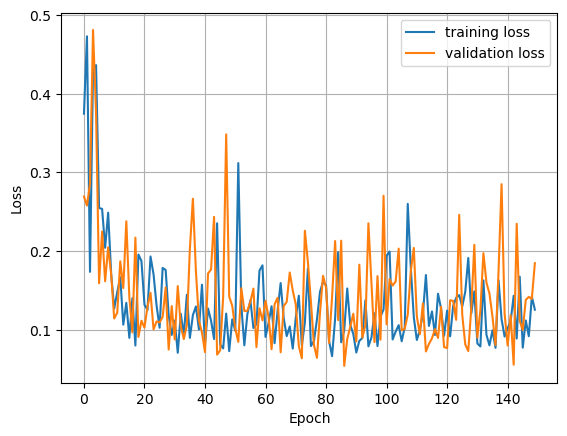

In [26]:
plt.plot(train_losses, label='training loss')
plt.plot(validation_losses, label='validation loss')
plt.legend();
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Cheking 

In [27]:
# Functions 
def CreatePointCloud(color_im, depth_im):
    color_raw = o3d.geometry.Image(color_im)
    depth_raw = o3d.geometry.Image(depth_im)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, 1000) # 
    PointCloud = o3d.geometry.PointCloud.create_from_rgbd_image(
      rgbd_image,o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)) # Creates Point Cloud from rgbd image
#     PointCloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down
    return PointCloud

def pick_points(pcd):
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()
    vis.destroy_window()
    numpy_array=np.asarray(pcd.points)
    point_id=vis.get_picked_points()

    return [numpy_array[point_id[0]],numpy_array[point_id[1]]]

def draw_arrow(pcd, points_real, points_extimated):
    lines=[[0,1],[2,3]]
    points = np.concatenate((points_real, points_extimated), axis=0)
    colors = [[1,0,0],[0,1,0]] # Red is REAL and Green is ESTIMATED
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),

    )
    line_set.colors=o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd,line_set])

In [28]:
inv_resize = transforms.Resize(480, interpolation=transforms.InterpolationMode.NEAREST)

In [29]:
# Model = AoRNet()
# Model.load_state_dict(torch.load('Modele/ResNet_3IN6OUT_100Epok_Din_Ddiff_L1LOSS_GIT.pt'))
# Model.eval()

In [30]:
# torch.manual_seed(101)
with torch.no_grad():
    for b, (X_validation, y_validation) in enumerate(validation_loader):
#         Apply the model
        
        X_validation = X_validation.to(device)
        y_validation = y_validation.to(device)
        

        y_val = Model(X_validation)
#         print(y_val.shape)
        for j in range(y_val.shape[0]):
            X_invNorm = inv_resize(X_validation[j])
            RGB_buff = X_invNorm[0].cpu().numpy()*255
#             RGB_buff = np.stack((X_invNorm[0].numpy(),X_invNorm[1].numpy(),X_invNorm[2].numpy()))*255
#             RGB_buff = np.transpose(RGB_buff, (1,2,0))
            RGB_buff = np.ascontiguousarray(RGB_buff, dtype=np.uint8)

            DEPTH_buff = X_invNorm[1].cpu().numpy()*5500
            PC = CreatePointCloud(RGB_buff, DEPTH_buff)
            PREDICTED = [[y_val[j][0].cpu().numpy(), y_val[j][1].cpu().numpy(), y_val[j][2].cpu().numpy()],
                         [y_val[j][3].cpu().numpy(), y_val[j][4].cpu().numpy(), y_val[j][5].cpu().numpy()]]
            REAL = [[y_validation[j][0].cpu().numpy(), y_validation[j][1].cpu().numpy(), y_validation[j][2].cpu().numpy()],
                    [y_validation[j][3].cpu().numpy(), y_validation[j][4].cpu().numpy(), y_validation[j][5].cpu().numpy()]]
            draw_arrow(PC, REAL, PREDICTED)

            print(f'--> BATCH: {b+1} <-- | --> ROW: {j} <--')
            print(f'----------------------------------------------------------------------------------------------')
            print(f'{"X1":>12} {"Y1":>12} {"Z1":>12} {"X2":>12} {"Y2":>12} {"Z2":>12}')
            print(f'{"PREDICTED:"}')
            print(f'[[{y_val[j][0]:12.5f}, {y_val[j][1]:12.5f}, {y_val[j][2]:12.5f}], [{y_val[j][3]:12.5f}, {y_val[j][4]:12.5f}, {y_val[j][5]:12.5f}]]')
            print(f'{"REAL:"}')
            print(f'[[{y_validation[j][0]:12.5f}, {y_validation[j][1]:12.5f}, {y_validation[j][2]:12.5f}], [{y_validation[j][3]:12.5f}, {y_validation[j][4]:12.5f}, {y_validation[j][5]:12.5f}]]')
            print(f'{"DIFFERENCE:"}')
            diff = np.abs(y_val.cpu().numpy()-y_validation.cpu().numpy())
            print(f'[[{diff[j][0]:12.5f}, {diff[j][1]:12.5f}, {diff[j][2]:12.5f}], [{diff[j][3]:12.5f}, {diff[j][4]:12.5f}, {diff[j][5]:12.5f}]]')
            print(f'----------------------------------------------------------------------------------------------')
# loss = criterion(y_val, y_validation.cuda())
# diff = np.abs(y_val.cpu().numpy()-y_validation.cpu().numpy())
# print(f'RMSE: {loss:.8f}')


--> BATCH: 1 <-- | --> ROW: 0 <--
----------------------------------------------------------------------------------------------
          X1           Y1           Z1           X2           Y2           Z2
PREDICTED:
[[     0.09483,     -0.32798,      1.16078], [     0.10940,      0.31908,      1.24591]]
REAL:
[[     0.09985,     -0.33658,      1.17800], [     0.10554,      0.18001,      1.30350]]
DIFFERENCE:
[[     0.00502,      0.00860,      0.01722], [     0.00387,      0.13907,      0.05759]]
----------------------------------------------------------------------------------------------
--> BATCH: 1 <-- | --> ROW: 1 <--
----------------------------------------------------------------------------------------------
          X1           Y1           Z1           X2           Y2           Z2
PREDICTED:
[[     0.01741,     -0.39266,      1.26866], [     0.02594,      0.40154,      1.34299]]
REAL:
[[     0.09985,     -0.33658,      1.17800], [     0.10554,      0.18001,      1.30350]]


--> BATCH: 2 <-- | --> ROW: 6 <--
----------------------------------------------------------------------------------------------
          X1           Y1           Z1           X2           Y2           Z2
PREDICTED:
[[     0.38823,     -0.15983,      1.41071], [     0.40310,      0.40945,      1.45715]]
REAL:
[[     0.44540,     -0.12920,      1.19000], [     0.44520,      0.35854,      1.24650]]
DIFFERENCE:
[[     0.05717,      0.03062,      0.22071], [     0.04210,      0.05092,      0.21065]]
----------------------------------------------------------------------------------------------
--> BATCH: 2 <-- | --> ROW: 7 <--
----------------------------------------------------------------------------------------------
          X1           Y1           Z1           X2           Y2           Z2
PREDICTED:
[[     0.15713,     -0.30527,      1.88187], [     0.16967,      0.49644,      1.80206]]
REAL:
[[     0.22962,     -0.17823,      1.68600], [     0.23168,      0.33602,      1.61100]]


KeyboardInterrupt: 

In [ ]:
Save the model
torch.save(Model.state_dict(), 'Modele/RN-A_L1-100E-.pt')